### Features to use for this
1. Player ID
2. Species (Protoss, Terran, Zerg)
3. APM (Actions Per Minute)
4. Count of "s" and "Base" /m
5. Count of hotkeys /m
5. Count of every hotkey uses

In [167]:
import numpy as np
import pandas as pd
import os
import csv
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import seaborn as sn
from matplotlib.pyplot import figure


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [168]:
train_file = './data/train.csv'

largest_column_count = 0

with open(train_file, 'r') as temp_f:
    # Read the lines
    lines = temp_f.readlines()

    for l in lines:
        # Count the column count for the current line
        column_count = len(l.split(',')) + 1

        # Set the new most column count
        largest_column_count = column_count if largest_column_count < column_count else largest_column_count

column_names = [i for i in range(0, largest_column_count)]
data_df = pd.read_csv(train_file, header=None, names=column_names)

In [169]:
# Action list to number definition
HOTKEYS = {}
for i in range(10):
    for j in range(3):
        HOTKEYS['hotkey'+str(i)+str(j)] = i*10

In [170]:
list_of_dicts = []
species = {'Protoss': 0, 'Terran': 1, 'Zerg': 2}
max_time = 25
first_seconds = 60
for index, row in data_df.iterrows():
    # Creates a dictionary of features for each player
    buffer_dict = {}
    buffer_dict['player_id'] = row[0]

    # Player's species (Protoss, Terran, Zerg) - 0, 1, 2
    buffer_dict['species'] = species[str(row[1])]

    # Player's first actions
    first_actions = []
    first_hotkeys = []
    first_hk_position = 0
    first_hk_actions = {"0": 0, "1": 0, "2": 0} # created, updated, used
    #buffer_dict['early_hk0_used'] = -1

    for i in range(2, len(row)):
        if pd.isnull(row[i]):
            break
        # Get the most used hotkey and number of clicks of other actions in the first "first_seconds" seconds
        if str(row[i]).startswith('t'):
            if int(str(row[i])[1:]) == first_seconds:
                if len(first_hotkeys) == 0:
                    buffer_dict['most_freq_early_hk'] = -1
                    buffer_dict['first_hk'] = -1
                    #buffer_dict['early_hk'] = -1
                else:
                    buffer_dict['most_freq_early_hk'] = max(set(first_hotkeys), key=first_hotkeys.count)
                    buffer_dict['first_hk'] = first_hotkeys[0]
                    #buffer_dict['early_hk'] = len(first_hotkeys)
                buffer_dict['early_s'] = first_actions.count('s')
                buffer_dict['early_base'] = first_actions.count('Base')
                buffer_dict['early_sm'] = first_actions.count('SingleMineral')
                buffer_dict['early_hk_created'] = first_hk_actions["0"]
                buffer_dict['early_hk_updated'] = first_hk_actions["1"]
                buffer_dict['early_hk_used'] = first_hk_actions["2"]
                break
        elif str(row[i]).startswith('hotkey'):
            if len(first_hotkeys) == 0:
                buffer_dict['first_hk_pos'] = first_hk_position
            # if str(row[i])[-1] == "2" and buffer_dict['early_hk0_used'] == -1:
            #     buffer_dict['early_hk0_used'] = len(first_hotkeys)
            first_hotkeys.append(HOTKEYS[str(row[i])])
            first_hk_actions[str(row[i])[-1]] += 1


        else:
            first_actions.append(str(row[i]))
            first_hk_position += 1

    # Player's APM calculation
    apm = 0

    # Disregard games with no timestamps
    if row.str.startswith('t').sum == 0:
        continue
    buffer_dict['game_time'] = row.str.startswith('t').sum() * 5 // 60 + 1

    # Count of button presses per minute for the first 30 minutes
    # buffer_dict['s_1'] corresponds to the number of "s" presses from 0:00 to 1:00
    buffer_dict['s'] = len(row[row == 's']) / buffer_dict['game_time']
    buffer_dict['base'] = len(row[row == 'Base']) / buffer_dict['game_time']
    buffer_dict['sm'] = len(row[row == 'SingleMineral']) / buffer_dict['game_time']

    keystrokes = row.count() - 2 - row.str.startswith('t').sum()
    # APM
    #print("*** INDEX: " + str(index) + " ***")
    #print(buffer_dict)
    # Count the number of hotkeys
    for i in range(10):
        buffer_dict['hk'+str(i)] = 0
        for j in range(3):
            mask = row == 'hotkey'+str(i)+str(j)
            buffer_dict['hk'+str(i)] += len(row[mask])
        buffer_dict['hk'+str(i)] /= buffer_dict['game_time']
    buffer_dict['apm'] = keystrokes / buffer_dict['game_time']
    if buffer_dict['game_time'] == 1:
        continue
    list_of_dicts.append(buffer_dict)

In [171]:
# Create a dataframe from the list of dictionaries
df = pd.DataFrame.from_records(list_of_dicts)
print(df)
nb_nan = df.isnull().sum()
print(nb_nan)

                                              player_id  species  \
0     http://eu.battle.net/sc2/en/profile/4234852/1/...        0   
1     http://eu.battle.net/sc2/en/profile/3074362/1/...        0   
2     http://eu.battle.net/sc2/en/profile/4234852/1/...        0   
3     http://eu.battle.net/sc2/en/profile/3074362/1/...        0   
4     http://eu.battle.net/sc2/en/profile/4234852/1/...        0   
...                                                 ...      ...   
3029     http://xx.battle.net/sc2/en/profile/405/1/MMA/        1   
3030  http://xx.battle.net/sc2/en/profile/410/1/STBo...        1   
3031     http://xx.battle.net/sc2/en/profile/405/1/MMA/        1   
3032  http://xx.battle.net/sc2/en/profile/410/1/STBo...        1   
3033     http://xx.battle.net/sc2/en/profile/405/1/MMA/        1   

      first_hk_pos  most_freq_early_hk  first_hk  early_s  early_base  \
0                8                  30        30       19           2   
1                9                  3

In [186]:
# Seperate data into features and target
X = df.drop(['player_id'], axis=1)
y = df['player_id']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [187]:
# Create a random forest classifier
model = RandomForestClassifier(random_state=2)
model.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred = model.predict(X_test)

# Calcul de l'erreur de prédiction
accuracy = model.score(X_test, y_test)
f1 = f1_score(y_test, y_pred, average='macro')
print('F1:', f1) # 0.87 0.83
print('Accuracy:', accuracy) # 0.93 0.91

F1: 0.8728298029355531
Accuracy: 0.9357495881383855


In [ ]:
# trolling
max_f1 = -1
max_acc = -1
max_f1_i = -1
max_f1_j = -1
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    for j in range(100):
        model = RandomForestClassifier(random_state=j)
        model.fit(X_train, y_train)

        # Prédictions sur les données de test
        y_pred = model.predict(X_test)

        # Calcul de l'erreur de prédiction
        accuracy = model.score(X_test, y_test)
        f1 = f1_score(y_test, y_pred, average='macro')
        if f1 > max_f1:
            max_f1 = f1
            max_acc = accuracy
            max_f1_i = i
            max_f1_j = j
print('F1:', max_f1)
print('Accuracy:', max_acc)
print('i:', max_f1_i)
print('j:', max_f1_j)

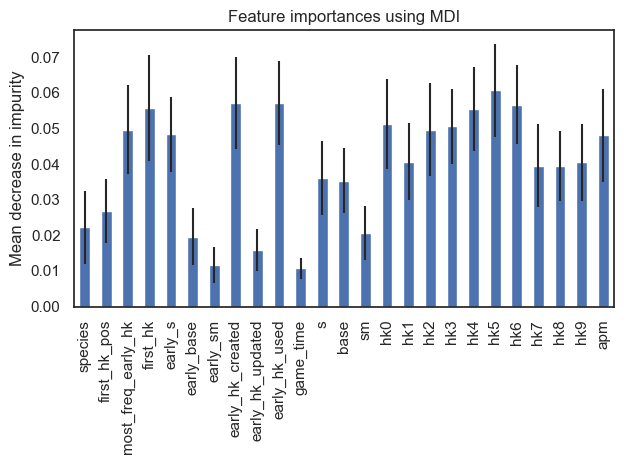

In [174]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


<Axes: >

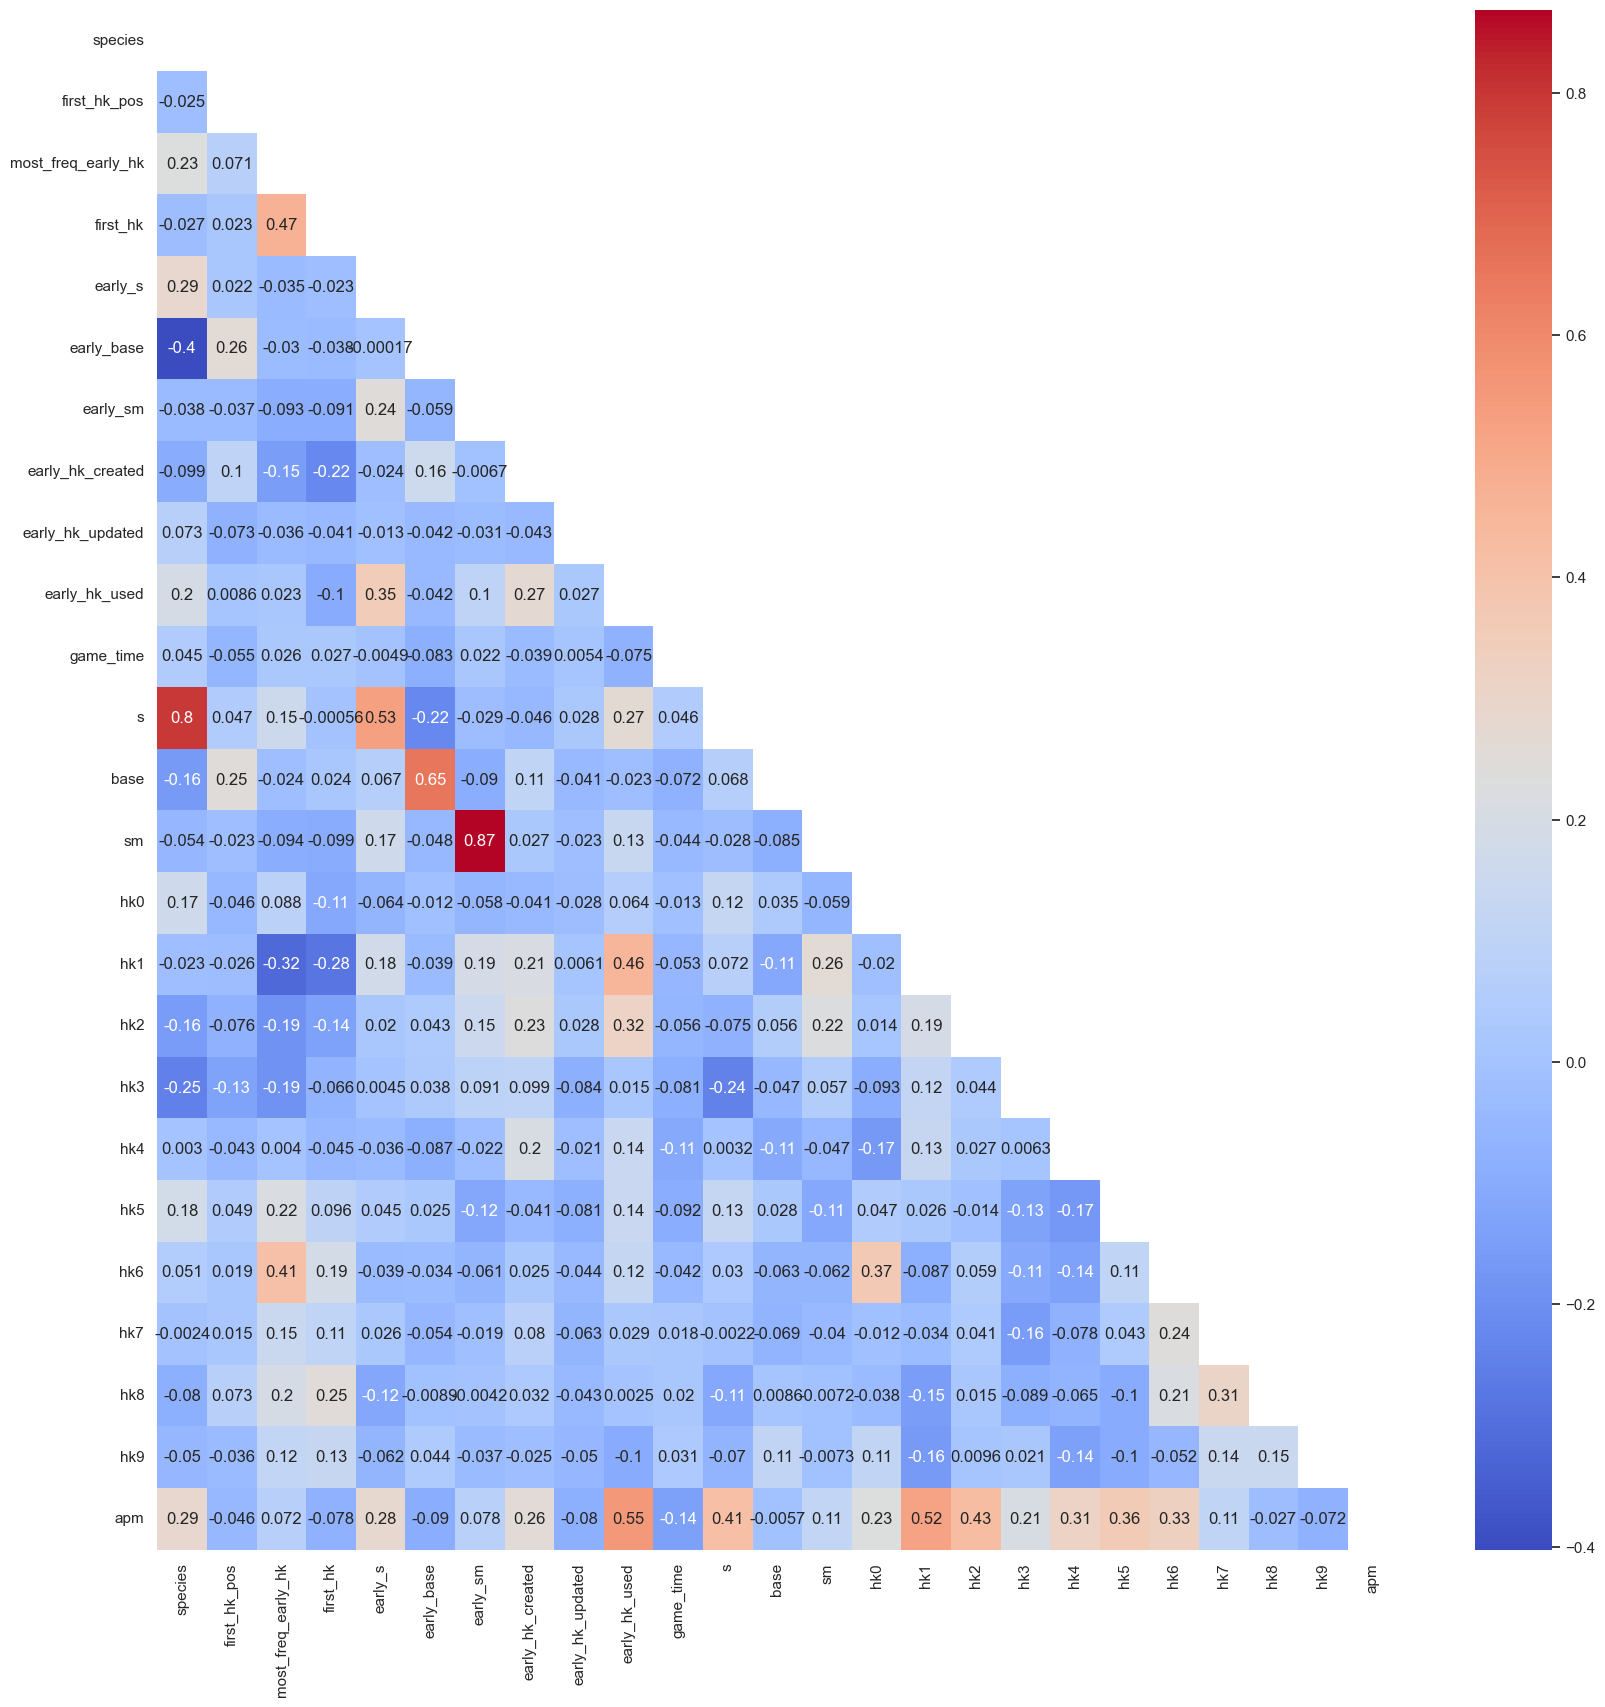

In [175]:
# Correlation heatmap
corrMatrix = df.drop(['player_id'], axis=1).corr()
figure(figsize=(20, 20))
sn.set_theme(style="white")
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
sn.heatmap(corrMatrix, annot=True, mask=mask, cmap='coolwarm')

In [176]:
### TEST ###
test_file = './data/TEST.CSV'

largest_column_count = 0

with open(train_file, 'r') as temp_f:
    # Read the lines
    lines = temp_f.readlines()

    for l in lines:
        # Count the column count for the current line
        column_count = len(l.split(',')) + 1

        # Set the new most column count
        largest_column_count = column_count if largest_column_count < column_count else largest_column_count

column_names = [i for i in range(0, largest_column_count)]
test_df = pd.read_csv(test_file, header=None, names=column_names)

In [177]:
### TEST
test_dicts = []
species = {'Protoss': 0, 'Terran': 1, 'Zerg': 2}
for index, row in test_df.iterrows():
    # Creates a dictionary of features for each player
    # Player's species (Protoss, Terran, Zerg) - 0, 1, 2
    buffer_dict = {'species': species[str(row[0])]}

    # Player's first actions
    first_actions = []
    first_hotkeys = []
    first_hk_position = 0
    first_hk_actions = {"0": 0, "1": 0, "2": 0} # created, updated, used

    for i in range(1, len(row)):
        if pd.isnull(row[i]):
            break
        # Get the most used hotkey and number of clicks of other actions in the first "first_seconds" seconds
        if str(row[i]).startswith('t'):
            if int(str(row[i])[1:]) == first_seconds:
                if len(first_hotkeys) == 0:
                    buffer_dict['most_freq_early_hk'] = -1
                    buffer_dict['first_hk'] = -1
                    #buffer_dict['early_hk'] = -1
                else:
                    buffer_dict['most_freq_early_hk'] = max(set(first_hotkeys), key=first_hotkeys.count)
                    buffer_dict['first_hk'] = first_hotkeys[0]
                    #buffer_dict['early_hk'] = len(first_hotkeys)
                buffer_dict['early_s'] = first_actions.count('s')
                buffer_dict['early_base'] = first_actions.count('Base')
                buffer_dict['early_sm'] = first_actions.count('SingleMineral')
                buffer_dict['early_hk_created'] = first_hk_actions["0"]
                buffer_dict['early_hk_updated'] = first_hk_actions["1"]
                buffer_dict['early_hk_used'] = first_hk_actions["2"]
                break
        elif str(row[i]).startswith('hotkey'):
            if len(first_hotkeys) == 0:
                buffer_dict['first_hk_pos'] = first_hk_position
            # if str(row[i])[-1] == "2" and buffer_dict['early_hk0_used'] == -1:
            #     buffer_dict['early_hk0_used'] = len(first_hotkeys)
            first_hotkeys.append(HOTKEYS[str(row[i])])
            first_hk_actions[str(row[i])[-1]] += 1


        else:
            first_actions.append(str(row[i]))
            first_hk_position += 1

    # Player's APM calculation
    apm = 0


    buffer_dict['game_time'] = row.str.startswith('t').sum() * 5 // 60 + 1
    # Count of button presses per minute for the first 30 minutes
    # buffer_dict['s_1'] corresponds to the number of "s" presses from 0:00 to 1:00
    buffer_dict['s'] = len(row[row == 's']) / buffer_dict['game_time']
    buffer_dict['base'] = len(row[row == 'Base']) / buffer_dict['game_time']
    buffer_dict['sm'] = len(row[row == 'SingleMineral']) / buffer_dict['game_time']
    keystrokes = row.count() - 1 - row.str.startswith('t').sum()

    # Count the number of hotkeys
    for i in range(10):
        buffer_dict['hk'+str(i)] = 0
        for j in range(3):
            mask = row == 'hotkey'+str(i)+str(j)
            buffer_dict['hk'+str(i)] += len(row[mask])
        buffer_dict['hk'+str(i)] /= buffer_dict['game_time']

    # APM
    buffer_dict['apm'] = keystrokes / buffer_dict['game_time']
    test_dicts.append(buffer_dict)

In [178]:
pred_df = pd.DataFrame.from_records(test_dicts).fillna(-1)
prediction = model.predict(pred_df)
print(len(prediction))
submission_dict = {'RowId': [], 'prediction': []}
for i in range(len(prediction)):
    submission_dict['RowId'].append(i+1)
    submission_dict['prediction'].append(prediction[i])
submission_df = pd.DataFrame(submission_dict)
submission_df.to_csv('submission.csv', index=False)
# with open('submission.csv', 'w', encoding="utf-8") as csvfile:
#     csvwriter = csv.writer(csvfile)
#     csvwriter.writerow(fields)
#     csvwriter.writerows(rows)

340
